In [1]:
import numba_transforms as nt
import numpy as np
import os, re, cv2
from cellpose import utils
from skimage.morphology import skeletonize
import warnings
import copy
import tools
import matplotlib.pyplot as plt
from create_centerline import create_centerline
from create_centerline import explore_poles
from PIL import Image
from skimage.morphology import skeletonize


segments_path = "cellpose_output/"

In [2]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

In [3]:
def masks_list(mask_img):
    vals = np.unique(mask_img)
    maskl = []
    for v in vals:
        if v>0:
            mask = mask_img==v
            maskl.append(mask*255)
    return maskl

In [4]:
dat=np.load(segments_path+segmented[0],allow_pickle=True).item()

In [9]:
masks=copy.deepcopy(masks_list(dat['masks']))

AttributeError: 'list' object has no attribute 'astype'

In [22]:
mask = np.flip(masks[0],axis=0).astype(np.uint8)

In [23]:
disT = cv2.distanceTransform(mask, cv2.DIST_L2, 3)

(0.0, 605.0, 0.0, 257.0)

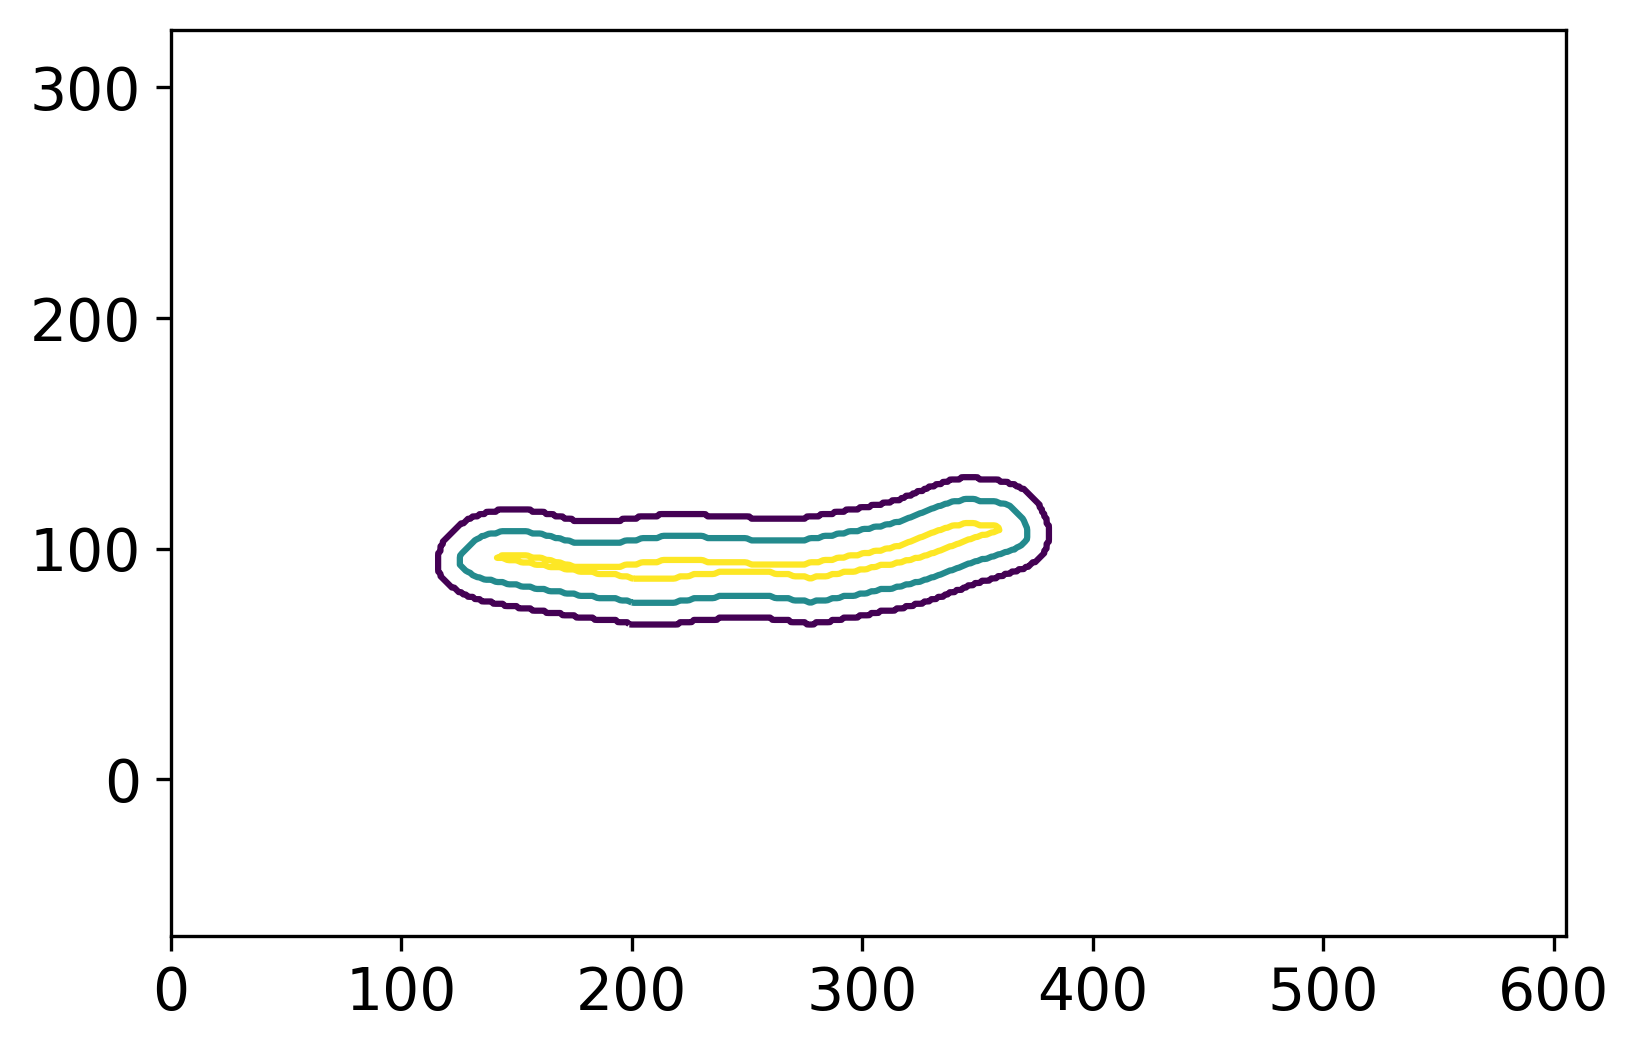

In [28]:
plt.contour(disT,[1,10,20])
plt.axis('equal')

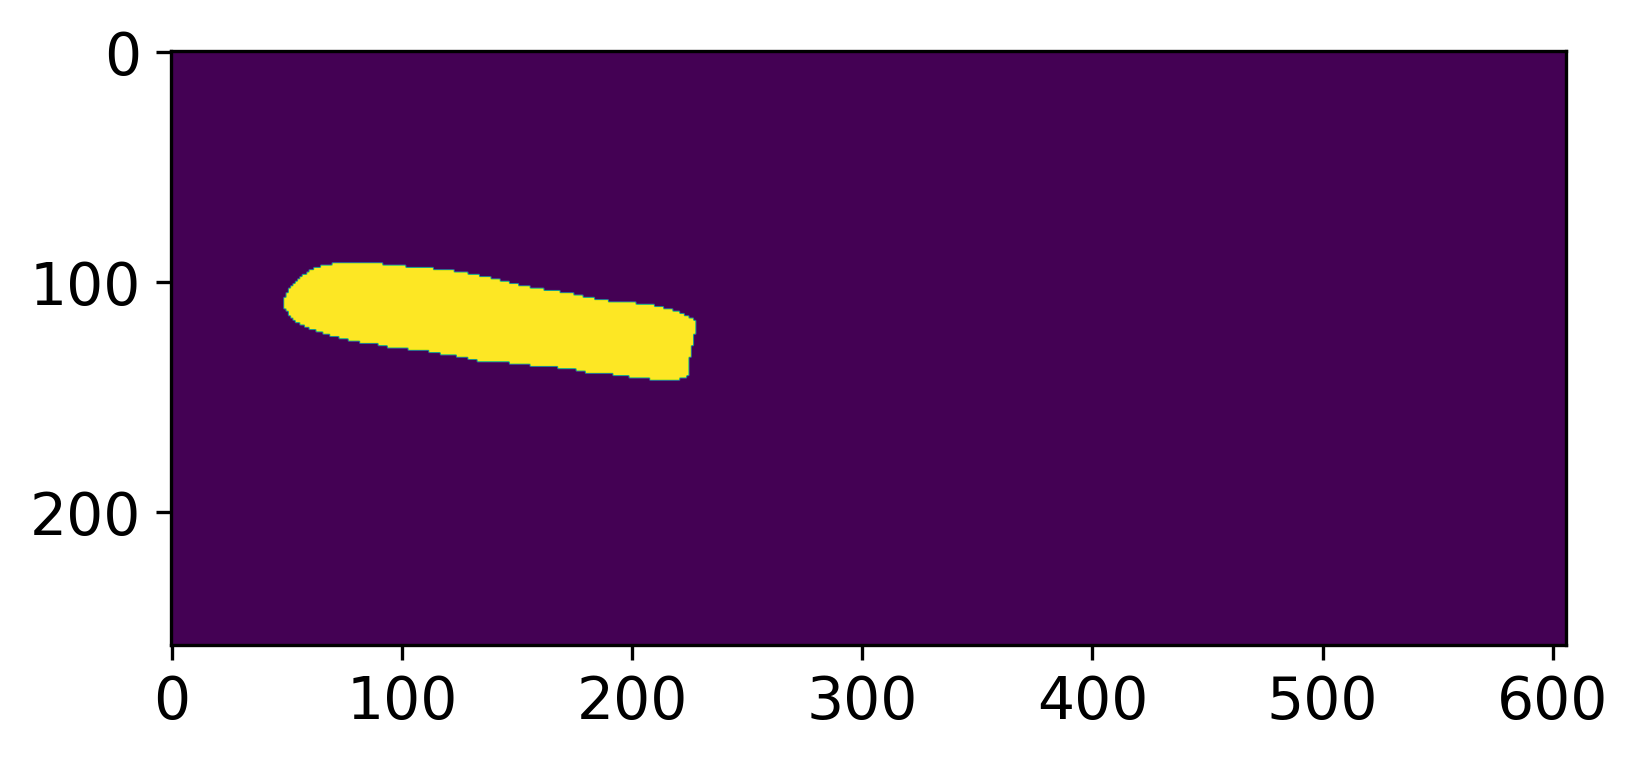

In [172]:
plt.imshow(masks[0])

In [117]:
flow_r = dat['flows'][0][0,:,:-100,0]
flow_g = dat['flows'][0][0,:,:-100,1]
flow_b = dat['flows'][0][0,:,:-100,2]
flow = np.dstack([flow_r,flow_g,flow_b]).astype(np.uint8)

In [150]:
np.shape(dat['flows'][4])

(3, 258, 606)

In [167]:
imdat = dat['flows'][4][1,:,:-100]

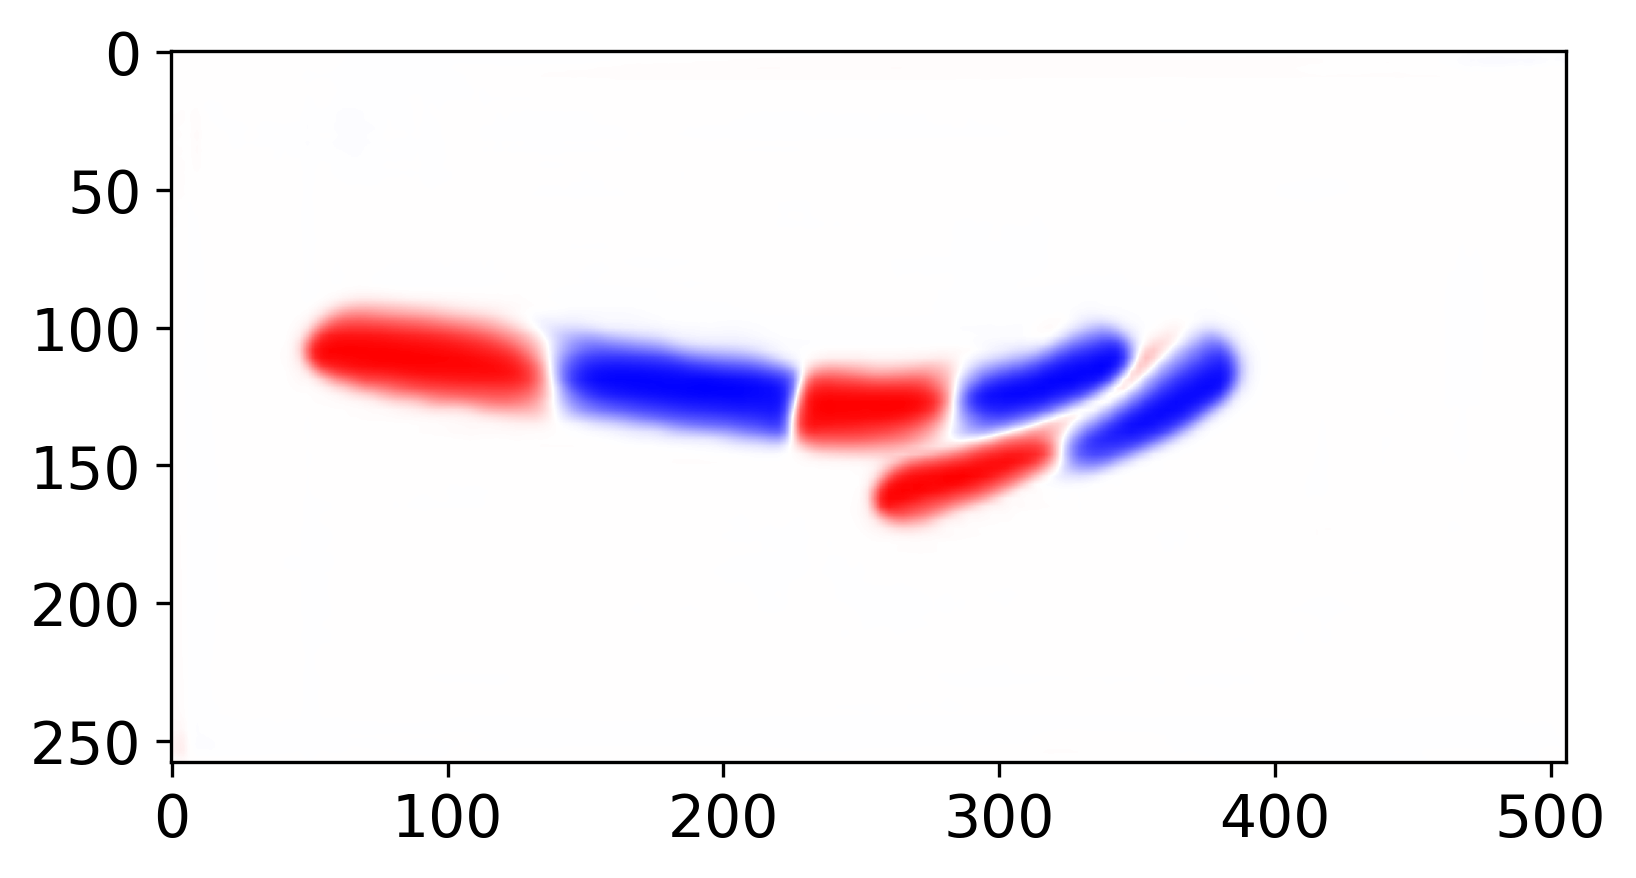

In [168]:
plt.imshow(imdat,cmap="bwr")

In [4]:
# Initialize lists.
outl_temp = []
maskl_temp = []
iml_temp = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original mask.
    maskl = masks_list(dat['masks'])
    maskl_temp.append(maskl)
    
    #Populate list with each original image
    iml = dat['img']
    iml_temp.append(iml)

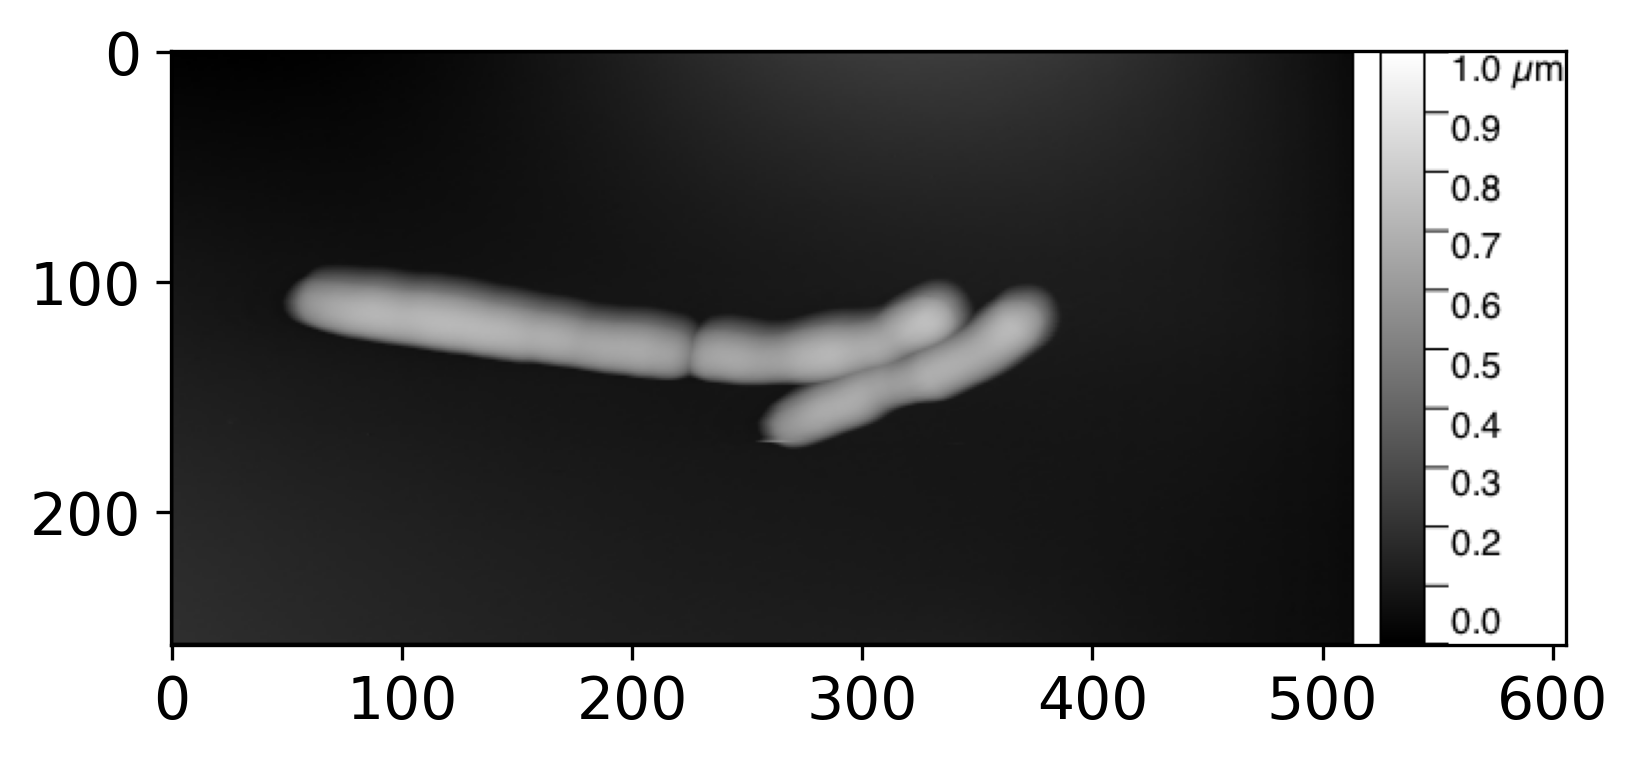

In [5]:
plt.imshow(iml_temp[30])

In [6]:
def only_poles(outl):
    '''Finds a bounding box of a mask and returns the poles of that image
    outl = a list of points
    
    Returns:
    
    poles = thepoles of that masks
    '''
    (hor,ver) = np.transpose(outl)
    l1 = min(hor)
    k1 = min(ver)
    l2 = max(hor)+1
    k2 = max(ver)+1
    sm_outl= [pt-np.array([l1,k1]) for pt in outl]
    bool_out = np.zeros((k2-k1,l2-l1))
    for i in range(k2-k1):
        for j in range (l2-l1):
            if np.any(np.all(np.array([j,i]) == sm_outl, axis=1)):
                bool_out[i,j]=1
    poles, centroid = explore_poles(bool_out)
    return poles + np.array([[l1,k1],[l1,k1]]), centroid + np.array([l1,k1])

In [7]:
(hor,ver) = np.transpose(outl)
l1 = min(hor)
k1 = min(ver)
l2 = max(hor)+1
k2 = max(ver)+1
sm_outl= [pt-np.array([l1,k1]) for pt in outl]
bool_out = np.zeros((k2-k1,l2-l1))
for i in range(k2-k1):
    for j in range (l2-l1):
        if np.any(np.all(np.array([j,i]) == sm_outl, axis=1)):
            bool_out[i,j]=1
poles, centroid = explore_poles(bool_out)

c:\users\sammu\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: too many values to unpack (expected 2)

In [8]:
plt.imshow(ex_im)
for out in outl_temp[32]:
    poles,centroid = only_poles(out)
    plt.plot(poles[0,0],poles[0,1],'r.')
    plt.plot(poles[1,0],poles[1,1],'r.')
    plt.plot(centroid[0],centroid[1],'b.')

NameError: name 'ex_im' is not defined

In [36]:
poles,centroid = only_poles(outl_temp[32][0])

C:\Users\sammu\OneDrive\Documents\GitHub\AFM_mycobacteria_automation\create_centerline.py:145: UserWarning: Sorting terminated early when points exceeded allowable distance
  warnings.warn('Sorting terminated early when points exceeded allowable distance')


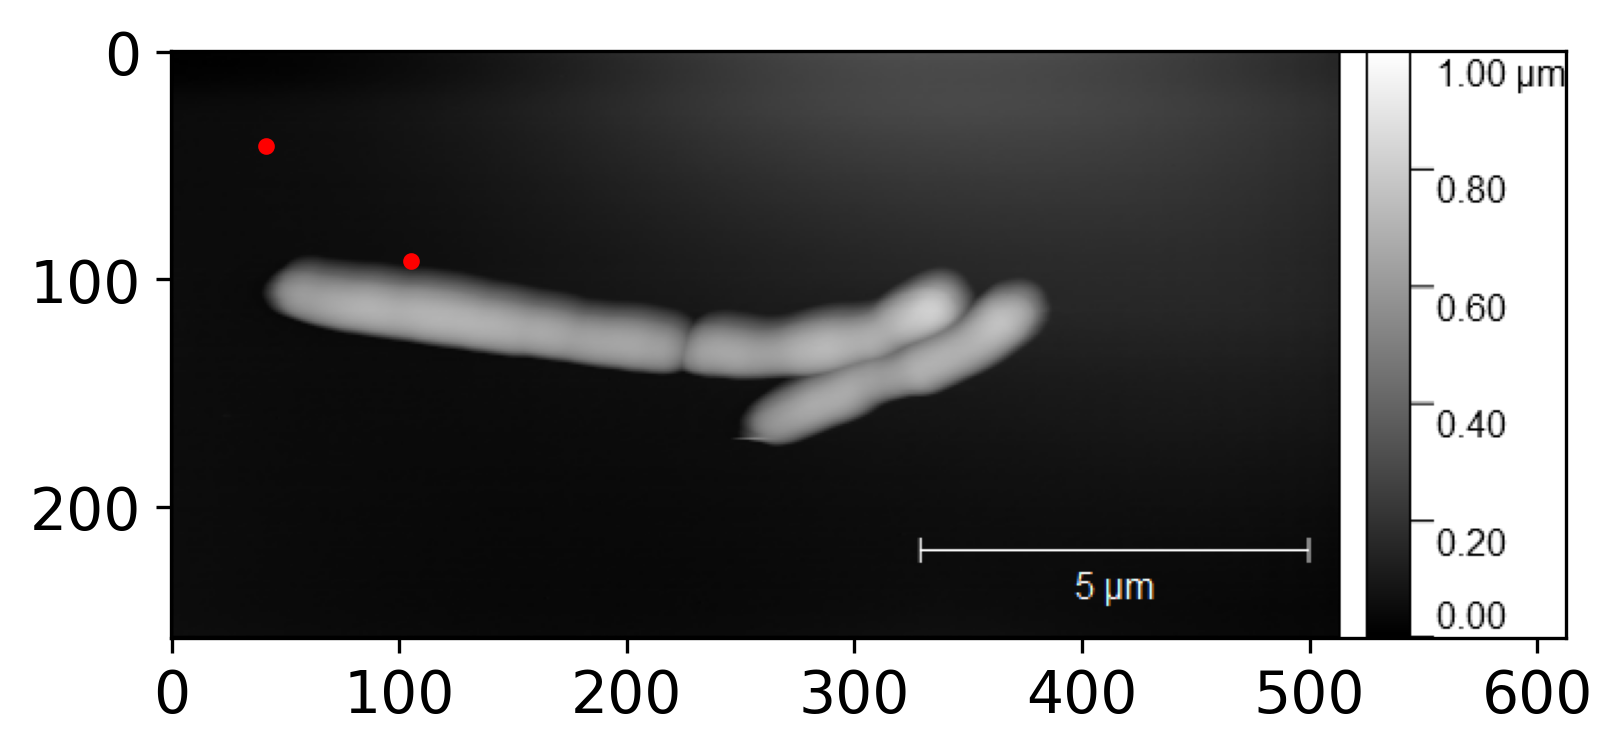

In [37]:
ex_im = np.array(Image.open('example_height.png'))
plt.imshow(ex_im)
plt.plot(poles[:,1],poles[:,0],'r.')

In [5]:
for mask_list in maskl_temp:
    for large_mask in mask_list:
        centerline = create_centerline(large_mask)

C:\Users\sammu\OneDrive\Documents\GitHub\AFM_mycobacteria_automation\create_centerline.py:145: UserWarning: Sorting terminated early when points exceeded allowable distance
  warnings.warn('Sorting terminated early when points exceeded allowable distance')
C:\Users\sammu\OneDrive\Documents\GitHub\AFM_mycobacteria_automation\create_centerline.py:152: UserWarning: path did not reach destination
  warnings.warn('path did not reach destination')
C:\Users\sammu\OneDrive\Documents\GitHub\AFM_mycobacteria_automation\create_centerline.py:243: UserWarning: curvature threshold exceeded. additional pruning executed in response
  warnings.warn('curvature threshold exceeded. additional pruning executed in response')


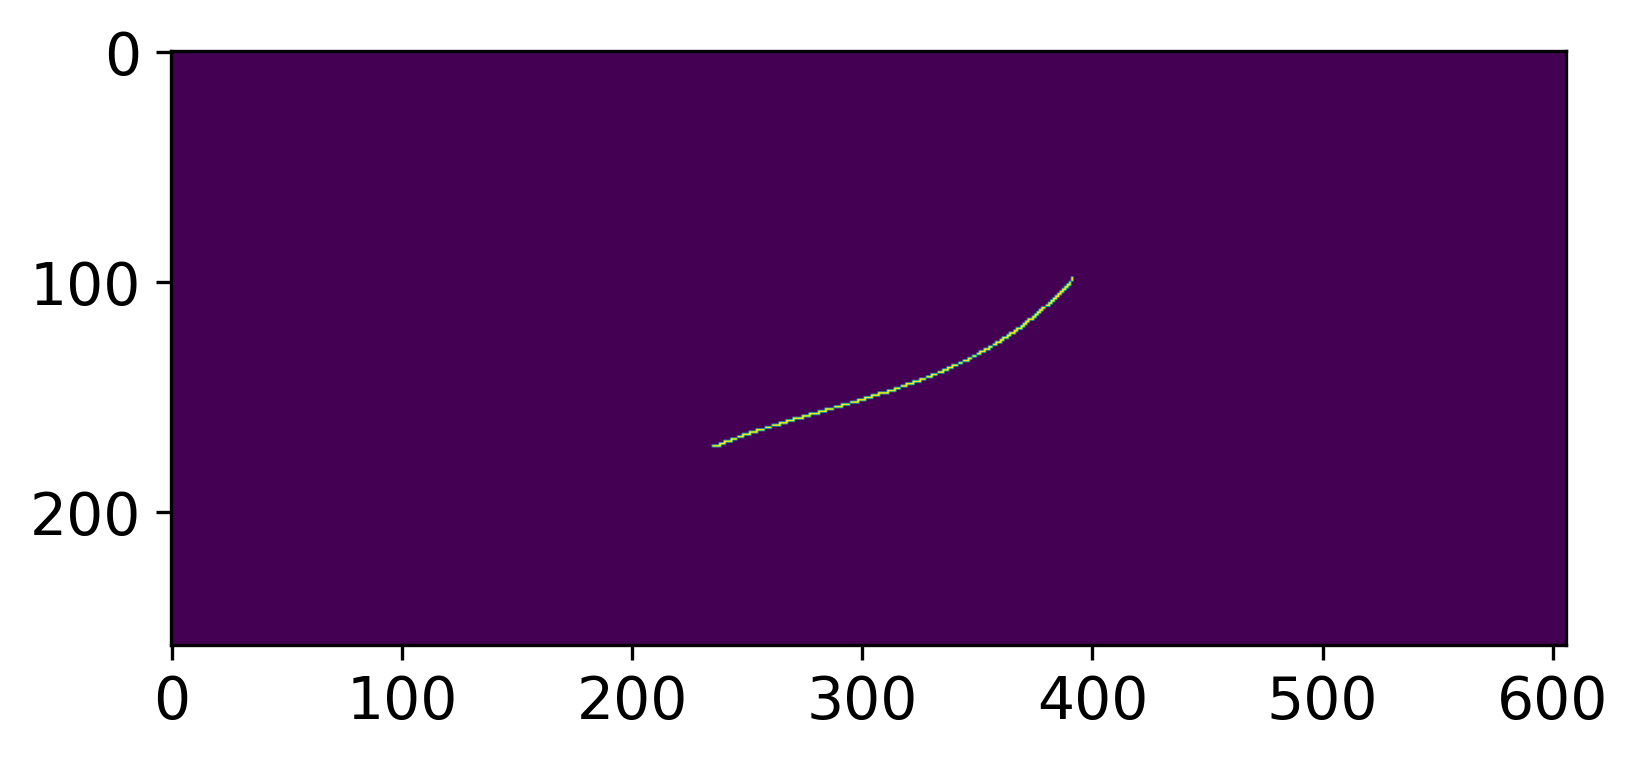

In [6]:
plt.imshow(centerline)